<font color=blue>Medical Charges Prediction for an Insurance Company Using Linear Regression</font>

The goal of this challenge is to develop a predictive model that can estimate medical charges for an insurance company using linear regression techniques. By leveraging historical data and relevant features, I aim to build a reliable model that can accurately forecast medical charges, enabling the insurance company to make informed decisions regarding pricing.

#### Import libraries

In [1]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

### Data Preparation 

In [2]:
#Read the CSV file
insurance_data = pd.read_csv("insurance.csv")

In [3]:
#Print dataset shape
print("insurance_data shape:", insurance_data.shape)

#Print first 5 rows
insurance_data.head()

insurance_data shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis (EDA) 

In [4]:
#Understanding the data
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


This DataFrame contains information on 1338 individuals. It includes columns such as age, sex, BMI (Body Mass Index), number of children, smoking status, region, and medical charges. The "age", "bmi", "children", and "charges" columns contain numerical data, while the "sex", "smoker", and "region" columns contain categorical data. The dataset is complete, with no missing values in any column.

In [5]:
#Investigate features with low and high cardinality
insurance_data.nunique().to_frame().rename(columns={0: "Value"})

,Value
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


Categorical columns with low or high cardinality can significantly impact the effectiveness of our model. Low cardinality, where a column has only one category, adds no unique insights, while high cardinality, where each row has its own category, can overwhelm the model. It's essential to preprocess these variables before analysis. For instance, grouping age and BMI into categories can simplify interpretation. Meanwhile, binary columns like sex and smoker status remain unchanged.

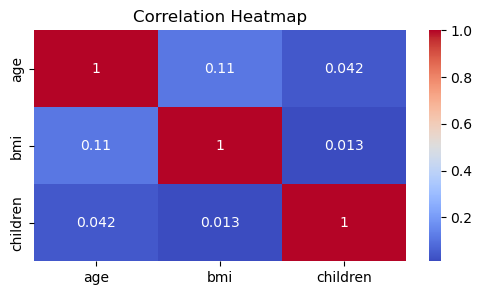

In [6]:
#Investigate multicollinearlity
#Set the size of the plot
plt.figure(figsize=(6, 3))
corr = insurance_data.select_dtypes("number").drop(columns="charges").corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

#Set title
plt.title("Correlation Heatmap")

#Display the plot
plt.show()

Multicollinearity refers to a situation in which two or more independent variables in a regression model are highly correlated with each other. It indicates that these variables provide redundant information, making it challenging for the model to estimate the unique effect of each variable on the dependent variable accurately. Based on the correlation coefficients above, such as 0.109 between age and bmi, and 0.042 between age and children, it seems that there isn't much multicollinearity between the variables age, bmi, and children. These numbers suggest that these variables are not strongly related to each other.

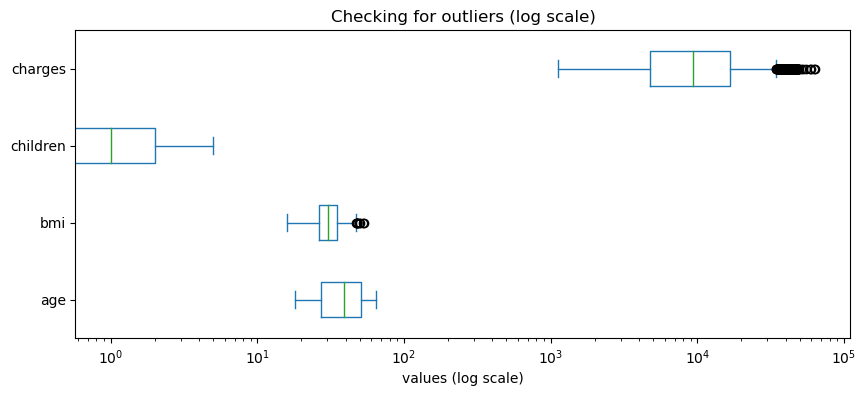

In [7]:
#Checking for outliers
fig, ax = plt.subplots(figsize=(10, 4))
insurance_data.plot(kind="box", vert=False, title="Checking for outliers (log scale)", ax=ax)
plt.xscale("log");
plt.xlabel("values (log scale)")
plt.show()

Handling outliers in charges and BMI can be difficult in insurance data. Extreme values might be real cases, but it's hard to tell if they're errors or not without more info. Removing them without understanding could affect our analysis. Also, high BMI or charges might happen due to serious health issues or special treatments. So, it's important to think carefully before making changes. That's why I chose not to handle outliers in this case. Additionally, I used a log scale to visualize all outliers within all features. Since the charges feature has extreme values, the normal scale would not permit us to visualize other features clearly in the same figure.

##### a. summary statistics of the variable charges in the dataset

In [8]:
#Summary statistics of the charges variable
insurance_data[["charges"]].describe()

,charges
count,1338.000000
mean,13270.422265
std,12110.011237
min,1121.873900
25%,4740.287150
50%,9382.033000
75%,16639.912515
max,63770.428010


Based on the summary statistics provided, the average charge for medical services is around 13,270.42, with charges ranging from as low as 1,121.87 to as high as 63,770.43. The charges vary a lot, as shown by the standard deviation of approximately 12,110.01. About 25% of the charges are below 4,740.29, and 75% are below 16,639.91. The middle charge, known as the median, is 9,382.03, indicating that half of the charges are less than this amount. This information tells us that there's a wide range of medical charges in the dataset, from low to high amounts.

##### b. Displaying a table that contains the number of people in each region 

In [9]:
#Count the number of people in each region and create a DataFrame
region_counts_df = insurance_data["region"].value_counts().reset_index()
region_counts_df.columns = ["Region", "Number of People"]

region_counts_df

,Region,Number of People
0,southeast,364
1,southwest,325
2,northwest,325
3,northeast,324


Based on the information provided in the table, it appears that the regions are almost equally represented in the dataset. The counts of individuals from each region are relatively similar, with the number of people ranging from 324 to 364 across the four geographic regions. This balanced distribution suggests that the dataset offers a fair representation of the population from each region.

##### c. Visualizing the relationship among all features using a scatterplot matrix

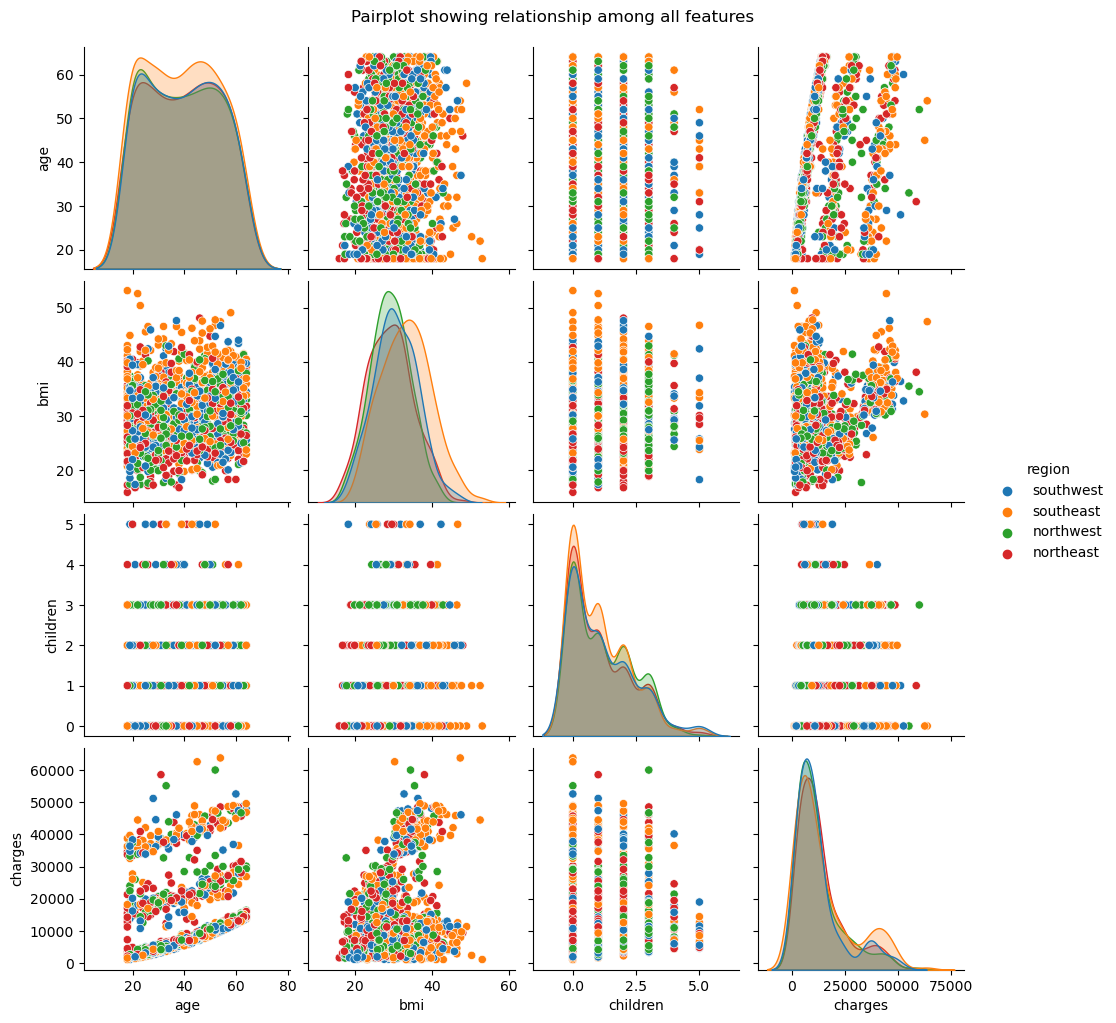

In [10]:
#Create a scatter plot matrix
sns.pairplot(insurance_data, hue="region")
#Set title
plt.suptitle("Pairplot showing relationship among all features", y=1.02)
#Display the plot
plt.show()

The scatterplot matrix graph provides valuable insights into the dataset's characteristics. It reveals certain difficulties in identifying linear relationships among the numerical variables, such as the relationship between BMI and age, which appears to lack a clear linear pattern. Interestingly, while BMI and age display normal distributions, indicating relatively balanced distributions of data points, the other variables demonstrate right-skewness. This skewness implies that the majority of data points are concentrated below the mean, a trend that holds true across all regions represented in the dataset.

### Feature Engineering 

In [11]:
#Function that create new ordinal feature
def create_ordinal_feature(new_column, feat_column, bins, labels):
    """Create a new ordinal categorical column based on binning.

    Parameters
    ----------
    new_column : str
        The name of the new column to be created.
    feat_column : str
        The name of the column to be transformed.
    bins : list
        The list of numbers defining the bin edges.
    labels : list
        The labels to be assigned to the bins in the new column.

    Returns
    -------
    None
    """
    
    #Create a new categorical column
    insurance_data[new_column] = pd.cut(insurance_data[feat_column], 
                                         bins=bins, 
                                         labels=labels
                                        )

In [12]:
#Get the age range
insurance_data[["age"]].describe().T[["min", "max"]]

,min,max
age,18.0,64.0


In [13]:
#Create categorical value for age feature
#Define the age bins
bins = [17, 30, 40, 50, 65]

#Define labels for the age ranges
labels = ["18-29", "30-39", "40-49", "50-64"]

#Call the function
create_ordinal_feature("age_group", "age", bins, labels)

In [14]:
#Print the categorical order
print(insurance_data["age_group"].unique())

['18-29', '30-39', '40-49', '50-64']
Categories (4, object): ['18-29' < '30-39' < '40-49' < '50-64']


In [15]:
#Get the bmi range
insurance_data[["bmi"]].describe().T[["min", "max"]]

,min,max
bmi,15.96,53.13


In [16]:
#Create categorical value for bmi feature
#Define the BMI bins
bins = [15.95, 18.5, 25, 30, 53.14]

#Define labels for the BMI categories
labels = ["Underweight", "Normal", "Overweight", "Obese"]

#Call the function
create_ordinal_feature("bmi_category", "bmi", bins, labels)

In [17]:
#Print the categorical order
print(insurance_data["bmi_category"].unique())

['Overweight', 'Obese', 'Normal', 'Underweight']
Categories (4, object): ['Underweight' < 'Normal' < 'Overweight' < 'Obese']


### Model creation and evaluation

#### Using Train Test Split

##### d. Train a model on the data

###### Initial features 

In [18]:
#Split data
X_initial = insurance_data[["age", "sex", "bmi", "children", "smoker", "region"]]
y_initial = insurance_data["charges"]

#Split the data into train and test sets
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(X_initial, 
                                                                                    y_initial, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42
                                                                                   )

In [19]:
#Create the Linear Regression model
def initial_model():
    """Create a pipeline for nominal encoding and Linear Regression.

    Returns
    -------
    model : Pipeline
        A pipeline object containing OneHotEncoder and LinearRegression.
    """
    
    #Define nominal and numerical features
    nominal_features = ["sex", "smoker", "region"]
    numerical_features = ["age", "bmi", "children"]

    #Create a pipeline for preprocessing categorical features
    nominal_pipeline = make_pipeline(
        OneHotEncoder(categories="auto", handle_unknown="ignore")
    )

    #Create a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("nominal", nominal_pipeline, nominal_features),
            ("numerical", "passthrough", numerical_features)
        ]
    )

    #Create the final pipeline including preprocessing and modeling steps
    model = make_pipeline(
        preprocessor,
        LinearRegression()
    )
    
    return model

In [20]:
#Call the model
model = initial_model()
#Fit the model
model.fit(X_train_initial, y_train_initial)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('numerical', 'passthrough',
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

##### e. Evaluate the model performance

In [21]:
#Function to evaluate model performance
def model_performance(y_test, y_pred):
    """Calculate evaluation metrics for model performance.

    Parameters
    ----------
    y_test : Series
        Actual target values.
    y_pred : Series
        Predicted target values.

    Returns
    -------
    None
        Prints out evaluation metrics: MAE, MSE, and R2.
    """
    
    #Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)

    #Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #Calculate R-squared (R2) score
    r2 = r2_score(y_test, y_pred)

    #Display the evaluation metrics
    print("Mean Absolute Error (MAE):", mae.round(2))
    print("Root Mean Squared Error (RMSE):", rmse.round(2))
    print("R-squared (R2) score:", r2.round(2))

In [22]:
#Get y prediction
y_pred = model.predict(X_test_initial)

#Print the evaluation metrics values
model_performance(y_test_initial, y_pred)

Mean Absolute Error (MAE): 4181.19
Root Mean Squared Error (RMSE): 5796.28
R-squared (R2) score: 0.78


These results provide insights into the performance of the regression model. With a Mean Absolute Error (MAE) of 4,181.19, it indicates the average absolute deviation between predicted and actual values. Additionally, the Root Mean Squared Error (RMSE) of approximately 5,796.28 portrays the root mean squared difference between predicted and actual values, suggesting substantial variability. Furthermore, the R-squared (R2) score of 0.78 indicates that approximately 78% of the variance in the dependent variable is explained by the independent variables in the model, suggesting a high level of predictive accuracy.

###### Transformed features 

In [23]:
#Split data
X_trans = insurance_data[["sex", "children", "smoker", "region", "age_group", "bmi_category"]]
y_trans = insurance_data[ "charges"]

#Split the data into train and test sets
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans,
                                                                            y_trans,
                                                                            test_size=0.2,
                                                                            random_state=42
                                                                           )

In [24]:
#Create the Linear Regression model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

def trans_model():
    """Create a pipeline with OneHotEncoder, OrdinalEncoder, and LinearRegression.

    Returns
    -------
    model
        Linear Regression model with nominal and ordinal encoded values.
    """
    
    #Define nominal, ordinal and numerical features
    nominal_features = ["sex", "smoker", "region"]
    ordinal_features = ["age_group", "bmi_category"]
    numerical_features = ["children"]

    #Create a pipeline for preprocessing categorical features
    nominal_pipeline = make_pipeline(
        OneHotEncoder(categories="auto", handle_unknown="ignore")
    )

    #Create a pipeline for preprocessing ordinal features
    ordinal_pipeline = make_pipeline(
        OrdinalEncoder(categories="auto")
    )

    #Create a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("nominal", nominal_pipeline, nominal_features),
            ("ordinal", ordinal_pipeline, ordinal_features),
            ("numerical", "passthrough", numerical_features)
        ]
    )

    #Create the final pipeline including preprocessing and modeling steps
    model = make_pipeline(
        preprocessor,
        LinearRegression()
    )
    
    return model

In [25]:
#Call the model
model = trans_model()
#Fit the model
model.fit(X_train_trans, y_train_trans)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['age_group',
                                                   'bmi_category']),
                                                 ('numerical', 'passthrough',
                                                  ['children'])])),
                ('linearregression', LinearRegression())])

In [26]:
#Evaluate the model
#Get y prediction
y_pred = model.predict(X_test_trans)

#Print the evaluation metrics values
model_performance(y_test_trans, y_pred)

Mean Absolute Error (MAE): 3960.37
Root Mean Squared Error (RMSE): 6173.53
R-squared (R2) score: 0.75


After transforming the ordinal variable, we observe a significant improvement in the regression model's performance. The Mean Absolute Error (MAE) decreases to 3,960.37, indicating a smaller average deviation between predicted and actual values. Moreover, the Root Mean Squared Error (RMSE) of approximately 6,173.53 helps us understand the average magnitude of the errors in the predicted values, providing additional insight into the model's performance. Additionally, the R-squared (R2) score increases to 0.75, indicating higher explanatory power and predictive accuracy, with approximately 75% of the variance in the dependent variable explained by the independent variables.

#### Using Cross-Validation

###### Initial features 

In [27]:
#Evaluate the model using cross-validation
def cross_val_model(X, y):
    """Calculate evaluation metrics for model performance using cross-validation.

    Parameters
    ----------
    X : matrix
        vector of columns.
    y : Series
        Actual target values.

    Returns
    -------
    None
        Prints out evaluation metrics: MAE, MSE, and R2.
    """
    
    #Perform 10-fold cross-validation
    mae = cross_val_score(model, X, y, cv=10, scoring="neg_mean_absolute_error")
    rmse = cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error")
    r2 = cross_val_score(model, X, y, cv=10, scoring="r2")

    #Print evaluation metrics
    print("Mean Absolute Error (MAE):", -mae.mean().round(2))
    print("Root Mean Squared Error (MSE):", np.sqrt(-rmse.mean()).round(2))
    print("R-squared (R2) Score:", r2.mean().round(2))

In [28]:
#Call the initial model
model = initial_model()

#Print the evaluation metrics values
cross_val_model(X_initial, y_initial)

Mean Absolute Error (MAE): 4196.61
Root Mean Squared Error (MSE): 6081.96
R-squared (R2) Score: 0.74


Based on these results, the cross-validation findings provide valuable insights into the regression model's performance. The Mean Absolute Error (MAE) of 4,196.61 indicates the average absolute difference between predicted and actual values, reflecting the model's accuracy in predicting medical charges. Additionally, the Root Mean Squared Error (RMSE) of approximately 6,081.96 provides a measure of the average magnitude of errors in the predicted values, offering further understanding of the model's performance. Furthermore, the R-squared (R2) score of 0.74 signifies that approximately 74% of the variance in the dependent variable is explained by the independent variables, indicating a moderate to high level of predictive accuracy.

###### Transformed features

In [29]:
#Call the initial model
model = trans_model()

#Print the evaluation metrics values
cross_val_model(X_trans, y_trans)

Mean Absolute Error (MAE): 4197.42
Root Mean Squared Error (MSE): 6456.9
R-squared (R2) Score: 0.71


Upon employing ordinal encoding, the model's performance slightly changed. The Mean Absolute Error (MAE) changed to 4,197.42, indicating a comparable average absolute deviation between predicted and actual values. However, the Root Mean Squared Error (RMSE) increased to 6,456.9, reflecting a increase in the average magnitude of errors in the predicted values. Furthermore, the R-squared (R2) score decreased to 0.71, indicating only that approximately 71% of the variance in the dependent variable is explained by the independent variables, signifying a lower level of predictive accuracy and explanatory power compared to the previous model.

##### f. Improving the model performance by Adding nonlinear relationship

In [30]:
#Create a PolynomialFeatures object
poly = PolynomialFeatures(degree=2)

#Transform the age feature
X_train_poly = poly.fit_transform(X_train_initial[["age"]])
X_test_poly = poly.transform(X_test_initial[["age"]])

In [31]:
#Considering obesity and smoker
X_train_smoker_obese = (X_train_initial["smoker"].map({"yes": 1, "no": 0}) * 
                                   (X_train_initial["bmi"] >= 30))
X_test_smoker_obese = (X_test_initial["smoker"].map({"yes": 1, "no": 0}) * 
                                  (X_test_initial["bmi"] >= 30))

In [32]:
#Combine the polynomial and smoker_obese features
X_train_combined = np.column_stack((X_train_poly, X_train_smoker_obese))
X_test_combined = np.column_stack((X_test_poly, X_test_smoker_obese))

#Create a linear regression model
model = LinearRegression()

#Train the model with the combined features
model.fit(X_train_combined, y_train_initial)

#Evaluate the model performance on the test set
y_pred = model.predict(X_test_combined)

#Print evaluation metrics
model_performance(y_test_initial, y_pred)

Mean Absolute Error (MAE): 4411.71
Root Mean Squared Error (RMSE): 6053.66
R-squared (R2) score: 0.76


The results obtained show that the model's predictive performance has improved compared to previous evaluations. The Mean Absolute Error (MAE) of 4,411.71 indicates that, on average, the model's predictions deviate by approximately 4,411.71 from the actual charges. The Mean Squared Error (MSE) of 36,646,797.87 represents the average squared difference between predicted and actual charges, suggesting less variability in the predictions compared to previous models. Additionally, the R-squared (R2) score of 0.76 indicates that approximately 76% of the variance in the medical charges can be explained by the independent variables in the model, suggesting a good level of predictive accuracy. These improvements were achieved by considering age as a nonlinear variable and combining it with the interaction effects of smoking and obesity, resulting in a single variable.

#### Improve the model performance

In [33]:
#Create smoker_obese feature to the dataset
insurance_data["smoker_obese"] = (insurance_data["smoker"].map({"yes": 1, "no": 0}) * 
                                   (insurance_data["bmi"] >= 30))

###### Initial features 

In [34]:
#Split data
X= insurance_data[["age", "sex", "bmi", "children", "smoker", "region", "smoker_obese"]]
y = insurance_data["charges"]

#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
#Define nominal and numerical features
nominal_features = ["sex", "smoker", "region"]
numerical_features = ["age", "bmi", "children", "smoker_obese"]

#Create a pipeline for preprocessing categorical features
nominal_pipeline = make_pipeline(
    OneHotEncoder(categories="auto", handle_unknown="ignore")
)

#Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("nominal", nominal_pipeline, nominal_features),
        ("numerical", "passthrough", numerical_features)
    ]
)

#Create the final pipeline including preprocessing and modeling steps
model = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [36]:
#Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('numerical', 'passthrough',
                                                  ['age', 'bmi', 'children',
                                                   'smoker_obese'])])),
                ('linearregression', LinearRegression())])

In [37]:
#Get y prediction
y_pred = model.predict(X_test)

#Print the evaluation metrics values
model_performance(y_test, y_pred)

Mean Absolute Error (MAE): 2486.32
Root Mean Squared Error (RMSE): 4458.27
R-squared (R2) score: 0.87


These results demonstrate a significant improvement in the model's performance. The Mean Absolute Error (MAE) of 2,486.32 indicates a notably reduced average absolute deviation between predicted and actual values. Moreover, the Root Mean Squared Error (RMSE) decreased to 4,458.27, suggesting a considerable reduction in the average magnitude of errors in the predicted values. Additionally, the R-squared (R2) score increased to 0.87, indicating that approximately 87% of the variance in the dependent variable is explained by the independent variables. This increase in predictive accuracy suggests that incorporating the smoker_obese feature, alongside the initial features with one-hot encoding, resulted in the best-performing model compared with the previous ones.

### Communicate Results

In [38]:
#Get model intercept and coefficients
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("intercept: ", intercept)
print("coefficients: ", coefficients)

intercept:  2580.2915757974624
coefficients:  [  251.21234553  -251.21234553 -6646.10470155  6646.10470155
   600.74177631   261.74391425   -91.41754115  -771.06814941
   261.81069615    56.57882221   469.78665221 19850.7363985 ]


In [39]:
#Get the feature names 
feature_names_nominal = (model.named_steps["columntransformer"]
                         .named_transformers_["nominal"]
                         .named_steps["onehotencoder"]
                         .get_feature_names_out()
                        )

#Combine feature names
feature_names = list(feature_names_nominal) + numerical_features

print("Feature names:", feature_names)

Feature names: ['sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'age', 'bmi', 'children', 'smoker_obese']


In [40]:
#Get a series of coefficients
feat_imp = pd.Series(coefficients, index=feature_names)

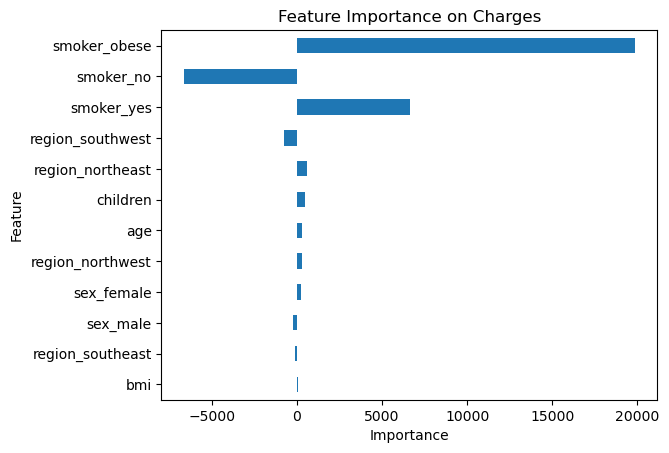

In [41]:
#Plot features and their influnce on the cost
feat_imp.sort_values(key=abs).plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance on Charges");

These findings reveal how different factors impact medical charges. For instance, being female is associated with higher charges, while being male is linked to lower charges. Smoking significantly increases charges, while living in certain regions can either raise or lower them. Age, BMI, and the number of children also affect charges, with older individuals, higher BMI, and more children leading to higher costs. Notably, being both a smoker and obese results in the highest charges. These results highlight the complex interplay of various factors in determining medical expenses, with lifestyle like smoking and obesity playing a significant role.